In [13]:
import pandas as pd
import numpy as np
import requests

# available choices of search key words can be found from this link:
# http://www.patentsview.org/api/patent.html

In [4]:
# api_url = 'http://www.patentsview.org/api/patents/query?\
# q={"_and":[\
# {"_gte":{"patent_date":"2000-01-01"}}, \
# {"_text_all":{"patent_abstract":"P38-kinase"}}]}&\
# f=["patent_number","patent_date","assignee_organization","patent_title",\
# "patent_abstract","patent_num_combined_citations","inventor_first_name",\
# "inventor_last_name","app_type"]&\
# o={"page":1, "per_page":5000}'

In [24]:
api_url = 'http://www.patentsview.org/api/patents/query?\
q={"_and":[\
{"_gte":{"patent_date":"2000-01-01"}}, \
{"_contains":{"assignee_organization":"International Business Machine"}}]}&\
f=["patent_number","patent_date","assignee_organization","patent_title",\
"patent_abstract","patent_num_combined_citations","inventor_first_name",\
"inventor_last_name","cpc_category"]&\
o={"page":1, "per_page":1000}'

session = requests.Session()
session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))
raw_data = session.get(api_url)
txt = raw_data.json()

In [23]:
len(txt)

3

In [19]:
categories = []
for i in range(len(txt)):    
    categories.append(txt['patents'][i]['cpcs'])

In [20]:
categories

[[{'cpc_category': 'inventional'}, {'cpc_category': 'additional'}],
 [{'cpc_category': 'inventional'}, {'cpc_category': 'additional'}],
 [{'cpc_category': 'inventional'}]]

In [7]:
patent_numbers = []
assignees = []
inventors = []
patent_type = []
for patent in txt['patents']:
    patent_numbers.append(patent['patent_number'])
    assignees.append(list(patent['assignees'][0].values())[0])
    patent_type.append(patent['patent_type'])
    names = []
    for i in range(len(patent['inventors'])):
        inventor_name = ' '.join(list(patent['inventors'][i].values()))
        names.append(inventor_name)
    inventors.append(', '.join(names))

In [401]:
patent_urls = []
for patent_number in patent_numbers:
    patent_url = "http://patft.uspto.gov/netacgi/nph-Parser?Sect2=PTO1&\
Sect2=HITOFF&p=1&u=/netahtml/PTO/search-bool.html&r=1&f=G&l=50&d=PALL&\
RefSrch=yes&Query=PN/{}".format(patent_number)
    patent_urls.append(patent_url)

In [8]:
result = txt['patents']
result_df = pd.DataFrame(result)

In [9]:
# result_df['url'] = patent_urls
result_df['assignees'] = assignees
result_df['inventors'] = inventors
result_df['patent_type'] = patent_type

In [10]:
result_df = result_df.rename(columns={'patent_num_combined_citations':'citations'})

In [12]:
result_df.to_pickle('microsoft2000.pkd')

# 作死开始

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import nltk
from nltk.corpus import stopwords

In [214]:
abstract = list(result_df['patent_abstract'])

In [292]:
vectorizer = TfidfVectorizer(ngram_range=(3,3), stop_words=stopwords.words())

In [293]:
tfidf = vectorizer.fit_transform(abstract)

In [294]:
# from sklearn.cluster import AffinityPropagation

model = AffinityPropagation(preference=-5)
model.fit(tfidf)
cluster_centers_indices = model.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)

In [295]:
# -5: 15
n_clusters

15

In [296]:
k = 15
km_model = KMeans(n_clusters=k, init='k-means++', max_iter=50, n_init=2)
km_model.fit(tfidf)

order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]

In [297]:
names = vectorizer.get_feature_names()

In [298]:
cluster = dict()
for i in range(k):
    cluster[i] = []
    for ind in order_centroids[i, :15]:
        cluster[i].append(names[ind])

In [338]:
text = [s for l in list(cluster.values()) for s in l]
text = ' '.join(text)

from wordcloud import WordCloud, STOPWORDS
from os import path
from scipy.misc import imread
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS

In [339]:
#text = 'all your base are belong to us all of your base base base'
wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      background_color='white',
                      relative_scaling = 1.0,
                      width=800, height=600,
                      stopwords = STOPWORDS,
                  ).generate(text)

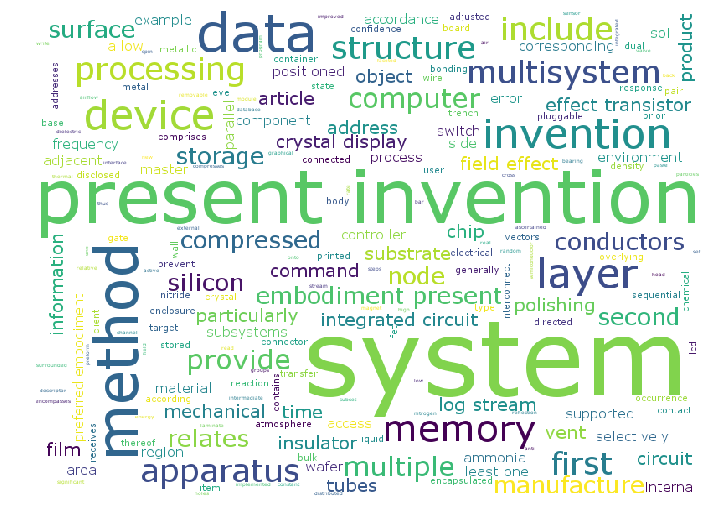

In [340]:
plt.figure(figsize=(12,9))
plt.imshow(wordcloud, aspect='auto',)
plt.axis("off")
plt.show()

In [299]:
cols = []
for i in range(k):
    cols.append('cluster'+str(i))

In [300]:
cluster_df = pd.DataFrame(cluster)
cluster_df.columns = cols

In [301]:
cluster_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cluster0,apparatus article manufacture,method apparatus article,method comprises steps,data storage device,stored data storage,database stored data,storage device connected,article manufacture computer,manufacture computer implemented,device connected computer,disclosed method comprises,least one user,accordance present invention,manufacture memory structure,article manufacture memory
cluster1,multisystem log stream,log stream compressed,adjusted real time,system multisystem environment,systems multisystem environment,stream compressed system,compressed system ascertained,environment frequency system,log stream adjusted,frequency systems multisystem,compressed systems multisystem,compressed system multisystem,time thus frequency,system compresses multisystem,log stream relative
cluster2,present invention provides,invention provides method,provides method system,provides method apparatus,printed circuit board,accordance present invention,layers least one,back channel region,invention provides system,cross bar switch,embodiment present invention,preferred embodiment present,selectively removable material,anti reflection layers,energy active material
cluster3,internal area enclosure,insulator vent tubes,conductors insulator vent,atmosphere prevent access,electrical conductors surrounded,prevent access internal,vent tubes positioned,positioned adjacent parallel,allow airflow internal,tubes positioned adjacent,adjacent parallel conductors,parallel conductors insulator,vent tubes allow,enclosure external atmosphere,includes electrical conductors
cluster4,distributed system structure,switch multiple memory,supported node controller,node controller receives,subsystems multiple master,address switch multiple,controller receives commands,structure contains address,nodes supported node,memory subsystems multiple,multiple memory subsystems,commands master device,system structure contains,multiple master devices,set nodes supported
cluster5,present invention relates,invention relates generally,relates generally new,particularly invention encompasses,invention relates method,thereof particularly invention,process thereof particularly,particularly present invention,onto module component,preform thermal paste,invention relates improved,high density pluggable,density pluggable connector,laminate magnet significant,holes integrated metal
cluster6,printed circuit board,spin valve sensor,computer program product,graphical user interface,accordance present invention,field effect transistor,includes least one,data storage system,chemical mechanical polishing,present invention includes,method system include,low dielectric constant,read write head,air bearing surface,random access memory
cluster7,silicon insulator soi,trench side wall,field effect transistor,field effect transistors,gate body contact,faceted crystal region,body contact structure,trench side walls,effect transistors fets,intermediate silicon layer,silicon base layer,type silicon base,bulk silicon substrate,bulk semiconductor substrate,soi field effect
cluster8,method present invention,one particles surface,subset component vectors,groups descriptor vectors,transfer error occurrence,error occurrence rate,nitrogen containing layer,target addresses sequential,addresses sequential address,data transfer error,information corresponding confidence,categorized information corresponding,corresponding confidence levels,maximum command response,command response time
cluster9,liquid crystal display,crystal display device,object present invention,color filter layer,crystal display lcd,side lcd panel,dynamically extendible table,first second substrates,first conductive layer,first second container,second container portions,crystal display cell,type liquid crystal,received intensity information,dark mesh material
